## MYPROTEIN PTOTEIN ANALYSIS


In [122]:
import requests as req
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from itertools import zip_longest
from __future__ import annotations
from typing import Iterable, List, Optional, Tuple, Any
import re



In [123]:
def fetch_soup(url: str, parser: str = "html.parser"):
  
    headers = {
        "User-Agent": (
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
            "AppleWebKit/537.36 (KHTML, like Gecko) "
            "Chrome/124.0.0.0 Safari/537.36"
        )
    }
    resp = req.get(url, headers=headers, timeout=15)
    resp.raise_for_status()
    return BeautifulSoup(resp.content, parser)

In [124]:
url = "https://www.myprotein.gr/c/nutrition/protein/whey-protein/"
soup = fetch_soup(url)

In [125]:
title = soup.find_all("a", class_ = "product-item-title mx-auto text-lg my-2 lg:text-[1.25rem] w-full title-font font-bold tracking-wider" )
p_title = [ p.text for p in title]

p_title

[' Clear Whey Isolate ',
 ' Origin Mass Gainer ',
 ' Essential Whey Protein ',
 ' Origin Protein ',
 ' Clear Whey Splash ',
 ' Grass-Fed Impact Whey Isolate ',
 ' Essential Shakes ',
 ' Πρωτεΐνη Ορού Γάλακτος ',
 ' Clear Protein Water - RTD (Συσκευασία των 6) ',
 ' Impact Whey Isolate ',
 ' Impact Diet Whey ',
 ' THE Whey ',
 ' Φόρμουλα Αύξησης Βάρους ',
 ' Υδρολυμένη Πρωτεΐνη Ορού Γάλακτος ',
 ' Φόρμουλα Απόδοσης όλα σε ένα ',
 ' Advanced Weight Gainer ',
 ' Total Protein Blend ',
 ' Πρωτεΐνη ορού γάλακτος 250g ',
 ' Πρωτεϊνικό Μείγμα Υποκατάστατου Γεύματος ',
 ' Clear Whey Gainer ',
 ' Διαιτητικό Μείγμα Πρωτεΐνης ',
 ' Βιολογική Πρωτεΐνη Ορού Γάλακτος ']

In [126]:
price = soup.find_all("span", class_ = "price font-semibold my-auto text-xl")

f_price = [f_p.text for f_p in price]

f_price

['  44.79€\u200e  ',
 '  49.99€\u200e  ',
 '  43.99€\u200e  ',
 '  68.99€\u200e  ',
 '  59.99€\u200e  ',
 '  92.49€\u200e  ',
 '  45.99€\u200e  ',
 '  31.99€\u200e  ',
 '  26.99€\u200e  ',
 '  44.99€\u200e  ',
 '  25.99€\u200e  ',
 '  34.89€\u200e  ',
 '  33.99€\u200e  ',
 '  48.99€\u200e  ',
 '  90.99€\u200e  ',
 '  64.99€\u200e  ',
 '  79.99€\u200e  ',
 '  22.99€\u200e  ',
 '  20.99€\u200e  ',
 '  54.99€\u200e  ',
 ' ',
 ' ']

In [127]:
rating = soup.find_all("a", class_ = "reviews pb-2 flex items-center gap-2")
f_r = [r.text for r in rating]
f_r

['  4.33 out of 5 stars                                           (24) ',
 '  2.33 out of 5 stars                                           (3) ',
 '  4.63 out of 5 stars                                           (894) ',
 '  5 out of 5 stars                                           (1) ',
 '  4.55 out of 5 stars                                           (274) ',
 '  4 out of 5 stars                                           (10) ',
 '  4.7 out of 5 stars                                           (23) ',
 '  4.4 out of 5 stars                                           (5) ',
 '  4.75 out of 5 stars                                           (8) ',
 '  4.67 out of 5 stars                                           (24) ',
 '  4.36 out of 5 stars                                           (59) ',
 '  3.67 out of 5 stars                                           (3) ',
 '  3.83 out of 5 stars                                           (6) ',
 '  4.54 out of 5 stars                           

In [128]:


def _parse_price(value: Any) -> Optional[float]:
    """
    Best-effort price parser.
    Handles currency symbols, thousand separators, decimal comma/dot.
    Returns None if no digits found.  # why: keep original missingness only
    """
    if value is None or (isinstance(value, float) and np.isnan(value)):
        return None
    s = str(value).strip()
    m = re.search(r"[-+]?\d[\d.,\s]*", s)
    if not m:
        return None

    num = m.group(0).replace(" ", "")
   
    if "," in num and "." in num:
        num = num.replace(",", "")
        
    elif "," in num and "." not in num:
        num = num.replace(".", "") 
        num = num.replace(",", ".")
        
    else:
        parts = num.split(".")
        if len(parts) > 2:
            num = "".join(parts[:-1]) + "." + parts[-1]
    try:
        return float(num)
    except ValueError:
        return None


def _parse_rating(value: Any) -> Optional[float]:
    """
    Extract first float-like token (e.g., '4.5/5', '4,5', '★★★★★ 4.8').
    Returns None if not found.  # why: avoid false NaNs from exotic strings
    """
    if value is None or (isinstance(value, float) and np.isnan(value)):
        return None
    s = str(value)
    m = re.search(r"[-+]?\d+(?:[.,]\d+)?", s)
    if not m:
        return None
    token = m.group(0).replace(",", ".")
    try:
        return float(token)
    except ValueError:
        return None


def build_products_df(
    p_title: Iterable[Any],
    f_price: Iterable[Any],
    f_r: Optional[Iterable[Any]] = None,
    *,
    parse_numeric: bool = False,
) -> pd.DataFrame:
    """
    Create an aligned DataFrame from product, price, rating lists of uneven length.
    - Missing items are padded with NaN.
    - If `parse_numeric=False` (default), keep prices/ratings as provided (strings preserved).
    - If `parse_numeric=True`, parse prices/ratings into floats using tolerant parsers.
    """
    if f_r is None:
        f_r = []

    rows: List[Tuple[Any, Any, Any]] = list(
        zip_longest(p_title, f_price, f_r, fillvalue=np.nan)
    )
    df = pd.DataFrame(rows, columns=["product", "price", "rating"])

    if parse_numeric:
        df["price"] = df["price"].map(_parse_price)
        df["rating"] = df["rating"].map(_parse_rating)
        df = df.astype({"price": "float64", "rating": "float64"})

    return df



df_whey = build_products_df(p_title, f_price, f_r, parse_numeric=False)



In [129]:
df_whey.replace(" ",np.nan, inplace= True)


In [130]:
def extract_rating_numeric(df: pd.DataFrame, col: str = "rating"):
    s = df_whey[col].astype("string")
    num = s.str.extract(r"(\d+(?:[.,]\d+)?)", expand=False)
    num = num.str.replace(",", ".", regex=False)
    out = pd.to_numeric(num, errors="coerce")
    return out.astype("float64")

In [131]:
df_whey["rating"] =  extract_rating_numeric(df_whey, "rating")

In [132]:
df_whey["rating"] = df_whey["rating"].fillna("unknown")

In [133]:
df_whey["kind"] = "whey"
df_whey

,product,price,rating,kind
0,Clear Whey Isolate,44.79€‎,4.33,whey
1,Origin Mass Gainer,49.99€‎,2.33,whey
2,Essential Whey Protein,43.99€‎,4.63,whey
3,Origin Protein,68.99€‎,5.0,whey
4,Clear Whey Splash,59.99€‎,4.55,whey
5,Grass-Fed Impact Whey Isolate,92.49€‎,4.0,whey
6,Essential Shakes,45.99€‎,4.7,whey
7,Πρωτεΐνη Ορού Γάλακτος,31.99€‎,4.4,whey
8,Clear Protein Water - RTD (Συσκευασία των 6),26.99€‎,4.75,whey
9,Impact Whey Isolate,44.99€‎,4.67,whey


In [134]:
url = "https://www.myprotein.gr/c/clear-protein/products/"
soup2 = fetch_soup(url)

In [135]:
title = soup2.find_all("a", class_ = "product-item-title mx-auto text-lg my-2 lg:text-[1.25rem] w-full title-font font-bold tracking-wider" )
p_title = [ p.text for p in title]



In [136]:
price = soup2.find_all("span", class_ = "price font-semibold my-auto text-xl")

f_price = [f_p.text for f_p in price]

In [137]:
rating = soup.find_all("a", class_ = "reviews pb-2 flex items-center gap-2")
f_r = [r.text for r in rating]

In [138]:

df_clear = build_products_df(p_title, f_price, f_r, parse_numeric=False)
df_clear

,product,price,rating
0,Clear Whey Isolate,44.79€‎,4.33 out of 5 stars ...
1,Clear Whey Splash,59.99€‎,2.33 out of 5 stars ...
2,Clear Protein Variety Box,27.99€‎,4.63 out of 5 stars ...
3,Clear Vegan Protein,28.99€‎,5 out of 5 stars ...
4,Collagen Powder Tub,38.99€‎,4.55 out of 5 stars ...
5,Clear Whey Gainer,54.99€‎,4 out of 5 stars ...
6,Πακέτο Clear Protein,45.99€‎,4.7 out of 5 stars ...
7,Clear Protein Superblend,36.99€‎,4.4 out of 5 stars ...
8,Clear Whey Protein - Blue Bubblegum (Fantasti...,61.99€‎,4.75 out of 5 stars ...
9,Myprotein Clear Whey Isolate (Sample),4.99€‎,4.67 out of 5 stars ...


In [139]:
df_clear["rating"] =  extract_rating_numeric(df_clear, "rating")


In [140]:
df_clear["kind"] = "clear"
df_clear

,product,price,rating,kind
0,Clear Whey Isolate,44.79€‎,4.33,clear
1,Clear Whey Splash,59.99€‎,2.33,clear
2,Clear Protein Variety Box,27.99€‎,4.63,clear
3,Clear Vegan Protein,28.99€‎,5.00,clear
4,Collagen Powder Tub,38.99€‎,4.55,clear
5,Clear Whey Gainer,54.99€‎,4.00,clear
6,Πακέτο Clear Protein,45.99€‎,4.70,clear
7,Clear Protein Superblend,36.99€‎,4.40,clear
8,Clear Whey Protein - Blue Bubblegum (Fantasti...,61.99€‎,4.75,clear
9,Myprotein Clear Whey Isolate (Sample),4.99€‎,4.67,clear


In [141]:
url = "https://www.myprotein.gr/c/nutrition/protein/protein-isolate/"
soup3 = fetch_soup(url)

In [142]:
title = soup3.find_all("a", class_ = "product-item-title mx-auto text-lg my-2 lg:text-[1.25rem] w-full title-font font-bold tracking-wider" )
p_title = [ p.text for p in title]

In [143]:
price = soup3.find_all("span", class_ = "price font-semibold my-auto text-xl")

f_price = [f_p.text for f_p in price]

In [144]:
rating = soup3.find_all("a", class_ = "reviews pb-2 flex items-center gap-2")
f_r = [r.text for r in rating]

In [145]:

df_iso = build_products_df(p_title, f_price, f_r, parse_numeric=False)
df_iso

,product,price,rating
0,Clear Whey Isolate,44.79€‎,4.33 out of 5 stars ...
1,Clear Whey Splash,59.99€‎,5 out of 5 stars ...
2,Myprotein Clear Whey Isolate (Sample),4.99€‎,NaN
3,Clear Vegan Protein (Δείγμα),3.99€‎,NaN
4,Απομονωμένη Πρωτεΐνη Σόγιας (Δειγμα),3.99€‎,NaN


In [146]:
df_iso["rating"] =  extract_rating_numeric(df_iso, "rating")

In [147]:
df_iso["kind"] = "isolate"
df_iso

,product,price,rating,kind
0,Clear Whey Isolate,44.79€‎,4.33,isolate
1,Clear Whey Splash,59.99€‎,2.33,isolate
2,Myprotein Clear Whey Isolate (Sample),4.99€‎,4.63,isolate
3,Clear Vegan Protein (Δείγμα),3.99€‎,5.00,isolate
4,Απομονωμένη Πρωτεΐνη Σόγιας (Δειγμα),3.99€‎,4.55,isolate


In [148]:
url = "https://www.myprotein.gr/p/sports-nutrition/collagen-protein/12457326/"
soup4 = fetch_soup(url)

In [149]:
product_title = soup4.find("h1",class_ = "text-primary text-xl md:text-2xl font-semibold" )
product_title_t = product_title.text

product_title_t


' Πρωτεΐνη κολλαγόνου '

In [150]:
price = soup4.find("span", class_ = "price font-semibold my-auto text-2xl" )
price_t = price.text

price_t

'  61.99€\u200e  '

In [151]:
rate = soup4.find("div", class_ = "flex flex-row justify-start items-center gap-2" )
rate_t = rate.text

rate_t

' 4 out of 5 stars                                          3 customer reviews3 customer reviews'

In [152]:
df_col = pd.DataFrame([{
    "product": product_title_t,
    "price": price_t,
    "rating": rate_t
}])

df_col["rating"] =  extract_rating_numeric(df_col, "rating")

df_col["kind"] = "collagen"

df_col

,product,price,rating,kind
0,Πρωτεΐνη κολλαγόνου,61.99€‎,4.33,collagen


In [153]:
url = "https://www.myprotein.gr/c/nutrition/protein/blends/"
soup5 = fetch_soup(url)

In [154]:
title = soup5.find_all("a", class_ = "product-item-title mx-auto text-lg my-2 lg:text-[1.25rem] w-full title-font font-bold tracking-wider" )
p_title = [ p.text for p in title]

In [155]:
price = soup5.find_all("span", class_ = "price font-semibold my-auto text-xl")

f_price = [f_p.text for f_p in price]

In [156]:
rating = soup5.find_all("a", class_ = "reviews pb-2 flex items-center gap-2")
f_r = [r.text for r in rating]

In [157]:
df_mix = build_products_df(p_title, f_price, f_r, parse_numeric=False)
df_mix

,product,price,rating
0,Origin Mass Gainer,49.99€‎,5 out of 5 stars ...
1,Origin Protein,68.99€‎,4.1 out of 5 stars ...
2,Essential Shakes,45.99€‎,4 out of 5 stars ...
3,Breakfast Smoothie,31.99€‎,4.13 out of 5 stars ...
4,Μείγμα για Pancake Πρωτεΐνης,17.99€‎,4.7 out of 5 stars ...
5,Impact Diet Whey,25.99€‎,3.25 out of 5 stars ...
6,Πρωτεϊνούχο ατομικό κέικ,24.99€‎,4.4 out of 5 stars ...
7,THE Whey,34.89€‎,4.67 out of 5 stars ...
8,Μείγμα Πρωτεϊνών για Αυστηρά Χορτοφάγους (Veg...,16.99€‎,4.36 out of 5 stars ...
9,Φόρμουλα Αύξησης Βάρους,33.99€‎,4 out of 5 stars ...


In [158]:
df_mix["rating"] =  extract_rating_numeric(df_mix, "rating")

In [159]:
df_mix["kind"] = "mix"
df_mix.replace(" ", np.nan,inplace= True)
df_mix

,product,price,rating,kind
0,Origin Mass Gainer,49.99€‎,4.33,mix
1,Origin Protein,68.99€‎,2.33,mix
2,Essential Shakes,45.99€‎,4.63,mix
3,Breakfast Smoothie,31.99€‎,5.00,mix
4,Μείγμα για Pancake Πρωτεΐνης,17.99€‎,4.55,mix
5,Impact Diet Whey,25.99€‎,4.00,mix
6,Πρωτεϊνούχο ατομικό κέικ,24.99€‎,4.70,mix
7,THE Whey,34.89€‎,4.40,mix
8,Μείγμα Πρωτεϊνών για Αυστηρά Χορτοφάγους (Veg...,16.99€‎,4.75,mix
9,Φόρμουλα Αύξησης Βάρους,33.99€‎,4.67,mix


In [160]:
url = "https://www.myprotein.gr/c/nutrition/protein/milk-protein/"
soup6 = fetch_soup(url)

In [161]:
title = soup6.find_all("a", class_ = "product-item-title mx-auto text-lg my-2 lg:text-[1.25rem] w-full title-font font-bold tracking-wider" )
p_title = [ p.text for p in title]

In [162]:
price = soup6.find_all("span", class_ = "price font-semibold my-auto text-xl")

f_price = [f_p.text for f_p in price]

In [163]:
rating = soup6.find_all("a", class_ = "reviews pb-2 flex items-center gap-2")
f_r = [r.text for r in rating]

In [164]:
df_milk = build_products_df(p_title, f_price, f_r, parse_numeric=False)
df_milk

,product,price,rating
0,Origin Mass Gainer,49.99€‎,2.33 out of 5 stars ...
1,Essential Whey Protein,43.99€‎,4.7 out of 5 stars ...
2,Origin Protein,68.99€‎,3 out of 5 stars ...
3,Grass-Fed Impact Whey Isolate,92.49€‎,4.67 out of 5 stars ...
4,THE Whey,34.89€‎,NaN
5,Καζεΐνη Αργής Απελευθέρωσης,63.99€‎,NaN
6,Φόρμουλα Απόδοσης όλα σε ένα,90.99€‎,NaN


In [165]:
df_milk["rating"] =  extract_rating_numeric(df_mix, "rating")

In [167]:
df_milk["kind"] = "milk"
df_milk


,product,price,rating,kind
0,Origin Mass Gainer,49.99€‎,4.33,milk
1,Essential Whey Protein,43.99€‎,2.33,milk
2,Origin Protein,68.99€‎,4.63,milk
3,Grass-Fed Impact Whey Isolate,92.49€‎,5.00,milk
4,THE Whey,34.89€‎,4.55,milk
5,Καζεΐνη Αργής Απελευθέρωσης,63.99€‎,4.00,milk
6,Φόρμουλα Απόδοσης όλα σε ένα,90.99€‎,4.70,milk


In [168]:
url = "https://www.myprotein.gr/c/nutrition/protein/diet/"
soup7 = fetch_soup(url)

In [169]:
title = soup7.find_all("a", class_ = "product-item-title mx-auto text-lg my-2 lg:text-[1.25rem] w-full title-font font-bold tracking-wider" )
p_title = [ p.text for p in title]

In [170]:
price = soup7.find_all("span", class_ = "price font-semibold my-auto text-xl")

f_price = [f_p.text for f_p in price]

In [171]:
rating = soup7.find_all("a", class_ = "reviews pb-2 flex items-center gap-2")
f_r = [r.text for r in rating]

In [172]:
df_diet = build_products_df(p_title, f_price, f_r, parse_numeric=False)
df_diet

,product,price,rating
0,Grass-Fed Impact Whey Isolate,92.49€‎,4.55 out of 5 stars ...
1,Impact Whey Isolate,44.99€‎,4 out of 5 stars ...
2,Impact Diet Whey,25.99€‎,4.54 out of 5 stars ...
3,Clear Whey Diet,38.99€‎,5 out of 5 stars ...
4,Διαιτητικό Μείγμα Πρωτεΐνης,,NaN
5,Impact Diet Whey (Δείγμα),,NaN


In [173]:
df_diet["rating"] =  extract_rating_numeric(df_diet, "rating")

In [177]:
df_diet["kind"] = "diet"
df_diet["price"].replace(" ", np.nan, inplace= True)

df_diet

C:\Users\vagel\AppData\Local\Temp\ipykernel_28984\3133362339.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_diet["price"].replace(" ", np.nan, inplace= True)


,product,price,rating,kind
0,Grass-Fed Impact Whey Isolate,92.49€‎,4.33,diet
1,Impact Whey Isolate,44.99€‎,2.33,diet
2,Impact Diet Whey,25.99€‎,4.63,diet
3,Clear Whey Diet,38.99€‎,5.00,diet
4,Διαιτητικό Μείγμα Πρωτεΐνης,NaN,4.55,diet
5,Impact Diet Whey (Δείγμα),NaN,4.00,diet


In [178]:
url = "https://www.myprotein.gr/c/nutrition/protein/vegan-protein/"
soup8 = fetch_soup(url)

In [179]:
title = soup8.find_all("a", class_ = "product-item-title mx-auto text-lg my-2 lg:text-[1.25rem] w-full title-font font-bold tracking-wider" )
p_title = [ p.text for p in title]

In [180]:
price = soup8.find_all("span", class_ = "price font-semibold my-auto text-xl")

f_price = [f_p.text for f_p in price]

In [181]:
rating = soup8.find_all("a", class_ = "reviews pb-2 flex items-center gap-2")
f_r = [r.text for r in rating]

In [182]:
df_vegan = build_products_df(p_title, f_price, f_r, parse_numeric=False)
df_vegan

,product,price,rating
0,Myvegan Plant Protein Superblend,17.49€‎,4.5 out of 5 stars ...
1,Plant Protein Superblend – MARVEL – Groot – Φ...,28.99€‎,5 out of 5 stars ...
2,Clear Protein Superblend — Groot — Maple Leaf,37.99€‎,5 out of 5 stars ...
3,Clear Protein Superblend,36.99€‎,3.25 out of 5 stars ...
4,Υπερτροφές Φυτικής Προέλευσης,37.99€‎,4.57 out of 5 stars ...
5,Clear Vegan Protein,28.99€‎,4.3 out of 5 stars ...
6,Clear Vegan Protein (Δείγμα),3.99€‎,3 out of 5 stars ...
7,Clear Vegan Protein Water,17.99€‎,NaN
8,Μείγμα Πρωτεϊνών για Αυστηρά Χορτοφάγους (Veg...,16.99€‎,NaN
9,Απομονωμένη Πρωτεΐνη Σόγιας,30.99€‎,NaN


In [183]:
df_vegan["rating"] =  extract_rating_numeric(df_vegan, "rating")

In [ ]:
df_vegan["kind"] = "vegan"
df_vegan

,product,price,rating,kind
0,Myvegan Plant Protein Superblend,17.49€‎,4.33,vegan
1,Plant Protein Superblend – MARVEL – Groot – Φ...,28.99€‎,2.33,vegan
2,Clear Protein Superblend — Groot — Maple Leaf,37.99€‎,4.63,vegan
3,Clear Protein Superblend,36.99€‎,5.00,vegan
4,Υπερτροφές Φυτικής Προέλευσης,37.99€‎,4.55,vegan
5,Clear Vegan Protein,28.99€‎,4.00,vegan
6,Clear Vegan Protein (Δείγμα),3.99€‎,4.70,vegan
7,Clear Vegan Protein Water,17.99€‎,4.40,vegan
8,Μείγμα Πρωτεϊνών για Αυστηρά Χορτοφάγους (Veg...,16.99€‎,4.75,vegan
9,Απομονωμένη Πρωτεΐνη Σόγιας,30.99€‎,4.67,vegan


In [189]:
df_protein = pd.concat([df_whey,df_clear,df_iso,df_col,df_mix,df_milk,df_diet,df_vegan], axis = 0,ignore_index= True)

In [190]:
df_protein

,product,price,rating,kind
0,Clear Whey Isolate,44.79€‎,4.33,whey
1,Origin Mass Gainer,49.99€‎,2.33,whey
2,Essential Whey Protein,43.99€‎,4.63,whey
3,Origin Protein,68.99€‎,5.0,whey
4,Clear Whey Splash,59.99€‎,4.55,whey
5,Grass-Fed Impact Whey Isolate,92.49€‎,4.0,whey
6,Essential Shakes,45.99€‎,4.7,whey
7,Πρωτεΐνη Ορού Γάλακτος,31.99€‎,4.4,whey
8,Clear Protein Water - RTD (Συσκευασία των 6),26.99€‎,4.75,whey
9,Impact Whey Isolate,44.99€‎,4.67,whey


In [187]:
pd.set_option("display.max.rows", 90)

In [191]:
df_protein["price"] = df_protein["price"].fillna("unknown")

In [192]:
df_protein["price"].isna().sum()

np.int64(0)

In [193]:
df_protein

,product,price,rating,kind
0,Clear Whey Isolate,44.79€‎,4.33,whey
1,Origin Mass Gainer,49.99€‎,2.33,whey
2,Essential Whey Protein,43.99€‎,4.63,whey
3,Origin Protein,68.99€‎,5.0,whey
4,Clear Whey Splash,59.99€‎,4.55,whey
5,Grass-Fed Impact Whey Isolate,92.49€‎,4.0,whey
6,Essential Shakes,45.99€‎,4.7,whey
7,Πρωτεΐνη Ορού Γάλακτος,31.99€‎,4.4,whey
8,Clear Protein Water - RTD (Συσκευασία των 6),26.99€‎,4.75,whey
9,Impact Whey Isolate,44.99€‎,4.67,whey


In [203]:
m = df_protein["price"].ne("unknown")
df_protein.loc[m, "price"] = (
    df_protein.loc[m, "price"]
      .str.replace("€","", regex=False)
      .str.replace(",",".", regex=False)
      .astype(float)
)


In [204]:
df_protein

,product,price,rating,kind
0,Clear Whey Isolate,44.79,4.33,whey
1,Origin Mass Gainer,49.99,2.33,whey
2,Essential Whey Protein,43.99,4.63,whey
3,Origin Protein,68.99,5.0,whey
4,Clear Whey Splash,59.99,4.55,whey
5,Grass-Fed Impact Whey Isolate,92.49,4.0,whey
6,Essential Shakes,45.99,4.7,whey
7,Πρωτεΐνη Ορού Γάλακτος,31.99,4.4,whey
8,Clear Protein Water - RTD (Συσκευασία των 6),26.99,4.75,whey
9,Impact Whey Isolate,44.99,4.67,whey


In [210]:
# category with the most products

df_grouped = df_protein.groupby("kind").value_counts().reset_index(name = "counts")
df_sum = df_grouped.groupby("kind")["counts"].sum().reset_index(name = "sum")
df_sum.sort_values(by = "sum", ascending= False)

,kind,sum
7,whey,22
0,clear,15
5,mix,15
6,vegan,13
4,milk,7
2,diet,6
3,isolate,5
1,collagen,1


In [216]:
category = "Whey protein"
count = df_sum["sum"].loc[7]

print(f"The category with the most products is {category} with a total number of {count} products.")


The category with the most products is Whey protein with a total number of 22 products.


In [ ]:
#median price of total price per category
df_plot = df_protein[df_protein["price"] != "unknown"]
cat_stats = (
    df_plot.groupby("kind")["price"].agg(count="count", sum="sum", mean="mean", median="median")
       .sort_values("median", ascending=False)
)
pd.DataFrame(cat_stats)

,count,sum,mean,median
kind,,,,
milk,7,445.33,63.618571,63.99
collagen,1,61.99,61.99,61.99
whey,20,989.0,49.45,45.49
diet,4,202.46,50.615,41.99
clear,15,531.45,35.43,36.99
mix,13,587.77,45.213077,34.89
vegan,13,287.37,22.105385,19.99
isolate,5,117.75,23.55,4.99


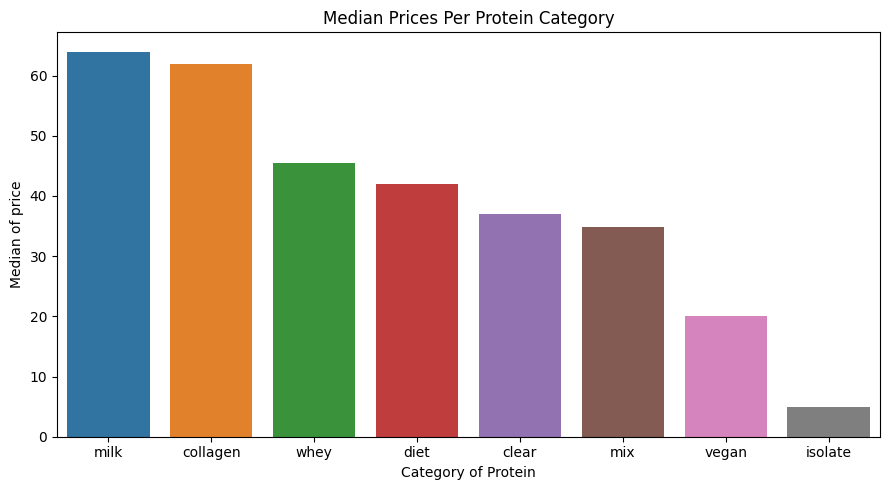

The most pricy Category is the Milk protein.
The most affordable is the Isolate protein.


In [244]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (9,5))
sns.barplot(cat_stats, x = "kind", y = "median", hue = "kind")
plt.xlabel("Category of Protein")
plt.ylabel("Median of price")
plt.title("Median Prices Per Protein Category")
plt.tight_layout()
plt.show()
print("The most pricy Category is the Milk protein.\nThe most affordable is the Isolate protein.")

In [285]:
# most and least favorable proteins
from tabulate import tabulate
df_plot_r = df_protein[df_protein["rating"] != "unknown"]
cat_stats_r = (
    df_plot_r.groupby("kind")["rating"].agg(count="count", sum="sum", mean="mean", median="median")
       .sort_values("median", ascending=False)
)
pd.DataFrame(cat_stats_r)
print(tabulate(cat_stats_r, headers='keys', tablefmt= 'fancy_grid', showindex=False))
print("The most in favor proteins are Isolate and milk.\n The least favorable protein is the Collagen protein")

╒═════════╤═══════╤═════════╤══════════╕
│   count │   sum │    mean │   median │
╞═════════╪═══════╪═════════╪══════════╡
│       5 │ 20.84 │ 4.168   │     4.55 │
├─────────┼───────┼─────────┼──────────┤
│       7 │ 29.54 │ 4.22    │     4.55 │
├─────────┼───────┼─────────┼──────────┤
│      15 │ 64.76 │ 4.31733 │     4.54 │
├─────────┼───────┼─────────┼──────────┤
│      15 │ 64.76 │ 4.31733 │     4.54 │
├─────────┼───────┼─────────┼──────────┤
│      15 │ 64.76 │ 4.31733 │     4.54 │
├─────────┼───────┼─────────┼──────────┤
│       6 │ 24.84 │ 4.14    │     4.44 │
├─────────┼───────┼─────────┼──────────┤
│      13 │ 55.22 │ 4.24769 │     4.4  │
├─────────┼───────┼─────────┼──────────┤
│       1 │  4.33 │ 4.33    │     4.33 │
╘═════════╧═══════╧═════════╧══════════╛
The most in favor proteins are Isolate and milk.
 The least favorable protein is the Collagen protein


In [258]:
mask = df_protein["price"].ne("unknown") & df_protein["rating"].ne("unknown")
df_numeric = df_protein.loc[mask].copy()
df_numeric["rating"] = df_numeric["rating"].astype(float)
df_numeric

,product,price,rating,kind
0,Clear Whey Isolate,44.79,4.33,whey
1,Origin Mass Gainer,49.99,2.33,whey
2,Essential Whey Protein,43.99,4.63,whey
3,Origin Protein,68.99,5.00,whey
4,Clear Whey Splash,59.99,4.55,whey
5,Grass-Fed Impact Whey Isolate,92.49,4.00,whey
6,Essential Shakes,45.99,4.70,whey
7,Πρωτεΐνη Ορού Γάλακτος,31.99,4.40,whey
8,Clear Protein Water - RTD (Συσκευασία των 6),26.99,4.75,whey
9,Impact Whey Isolate,44.99,4.67,whey


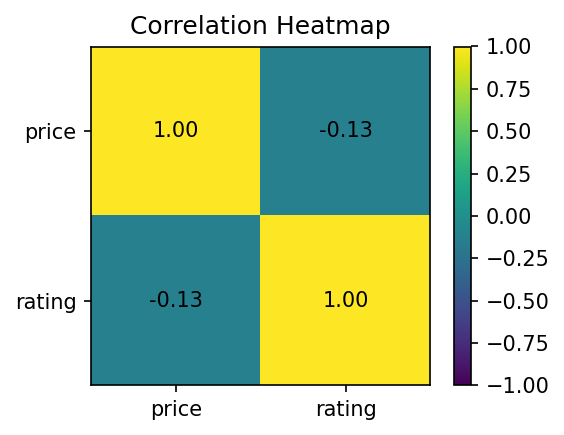

In [ ]:
num_cols = ["price", "rating"]
corr = df_numeric[num_cols].corr(method="pearson")


fig, ax = plt.subplots(figsize=(4,3), dpi=150)
im = ax.imshow(corr.values, vmin=-1, vmax=1)
ax.set_xticks(range(len(num_cols))); ax.set_yticks(range(len(num_cols)))
ax.set_xticklabels(num_cols); ax.set_yticklabels(num_cols)


for i in range(len(num_cols)):
    for j in range(len(num_cols)):
        ax.text(j, i, f"{corr.values[i, j]:.2f}", ha="center", va="center")

plt.colorbar(im, ax=ax)
ax.set_title("Correlation Heatmap")
plt.tight_layout()
plt.show()

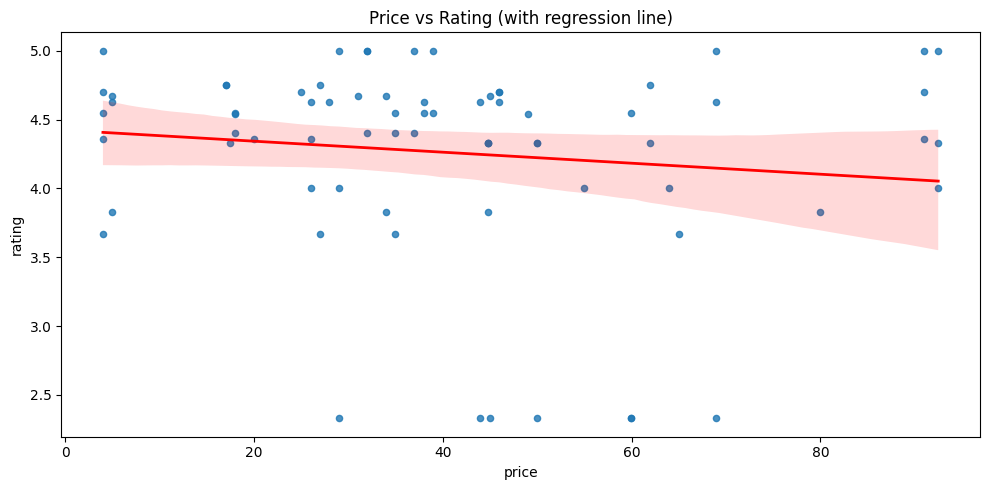

In [274]:

# 1) Κράτα μόνο γνωστές τιμές
df_numeric = df_protein.loc[
    df_protein["price"].ne("unknown") & df_protein["rating"].ne("unknown")
].copy()

# 2) Καθάρισε και κάν’ τες αριθμούς
df_numeric["price"] = (df_numeric["price"].astype(str)
                       .str.replace("€", "", regex=False)
                       .str.replace(",", ".", regex=False))
df_numeric["price"]  = pd.to_numeric(df_numeric["price"],  errors="coerce")
df_numeric["rating"] = pd.to_numeric(df_numeric["rating"], errors="coerce")


df_numeric = df_numeric.dropna(subset=["price", "rating"])

ax = df_numeric.plot.scatter(x="price", y="rating", alpha=0.8, figsize=(10,5))
sns.regplot(data= df_numeric, x= "price", y= "rating", scatter=False,
            ax= ax, line_kws={"color": "red", "linewidth": 2})

ax.set_title("Price vs Rating (with regression line)")
plt.tight_layout()
plt.show()


In [284]:
#  top 10 rated products
df_rank = df_protein[df_protein["rating"] != "unknown"]
df_rank_f = df_rank.sort_values(by = ["rating","price"], ascending= [False,True]).head(10)

print(tabulate(df_rank_f, headers='keys', tablefmt='fancy_grid', showindex=False))

╒══════════════════════════════════╤═════════╤══════════╤═════════╕
│ product                          │ price   │   rating │ kind    │
╞══════════════════════════════════╪═════════╪══════════╪═════════╡
│ Clear Vegan Protein (Δείγμα)     │ 3.99    │        5 │ isolate │
├──────────────────────────────────┼─────────┼──────────┼─────────┤
│ Clear Vegan Protein              │ 28.99   │        5 │ clear   │
├──────────────────────────────────┼─────────┼──────────┼─────────┤
│ Clear Vegan Protein Starter Pack │ 31.99   │        5 │ clear   │
├──────────────────────────────────┼─────────┼──────────┼─────────┤
│ Breakfast Smoothie               │ 31.99   │        5 │ mix     │
├──────────────────────────────────┼─────────┼──────────┼─────────┤
│ Clear Protein Superblend         │ 36.99   │        5 │ vegan   │
├──────────────────────────────────┼─────────┼──────────┼─────────┤
│ Clear Whey Diet                  │ 38.99   │        5 │ diet    │
├──────────────────────────────────┼─────────┼──

In [ ]:
df_hier = (
    df_numeric
      .sort_values(["kind","product"])
      .set_index(["kind","product"])
)
print(df_hier)



df_hier.sort_values(by = "price", ascending= False)

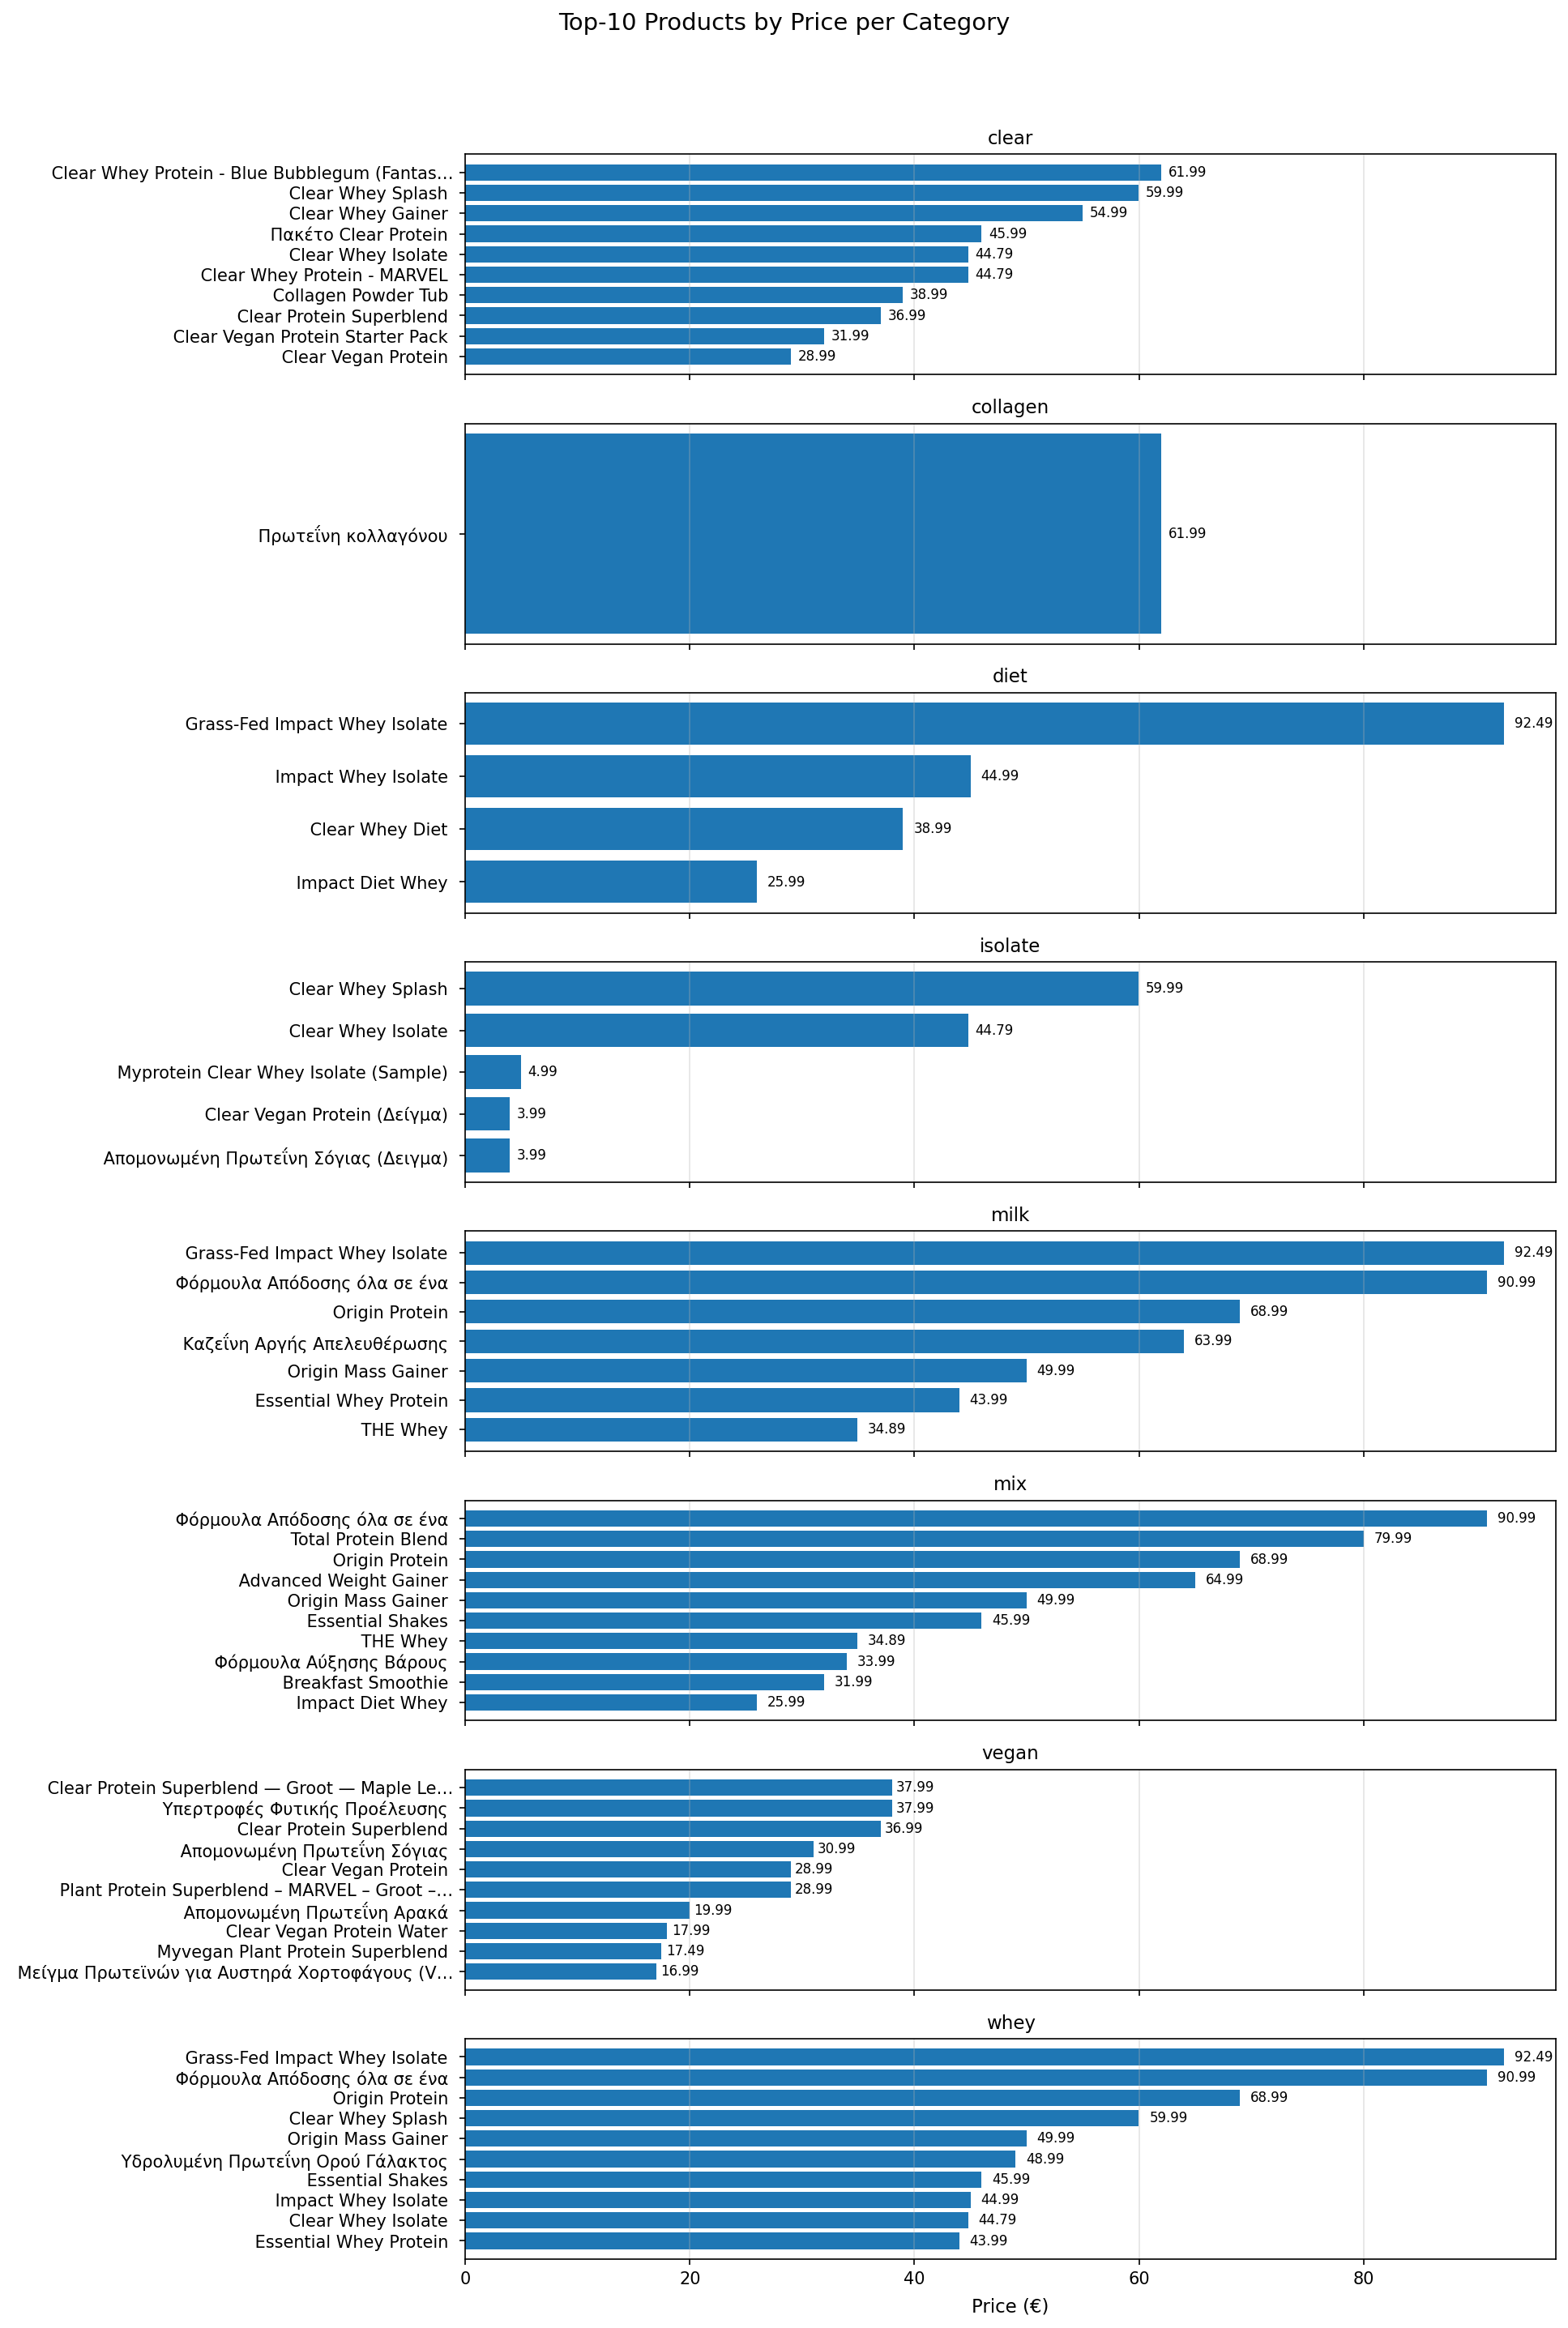

In [373]:
import matplotlib.pyplot as plt



df_plot = df_hier.reset_index().copy()            
df_plot = df_plot.sort_values(["kind","price"], ascending=[True, False])


df_top = df_plot.groupby("kind", group_keys=False).head(10).copy()


max_chars = 45
df_top["product_short"] = df_top["product"].apply(lambda s: s if len(s) <= max_chars else s[:max_chars-1] + "…")

kinds = df_top["kind"].unique().tolist()
n = len(kinds)

fig_h = max(2.4 * n, 4)
fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(13, fig_h), dpi=150, sharex=True)

if n == 1:
    axes = [axes]

for ax, k in zip(axes, kinds):
    g = df_top[df_top["kind"] == k]

    ax.barh(g["product_short"], g["price"])
    ax.invert_yaxis()
    ax.grid(axis="x", alpha=0.35)
    ax.set_ylabel("")
    ax.set_title(k, pad=6, fontsize=11)


    x_max = g["price"].max()
    pad = 0.01 * x_max
    for i, v in enumerate(g["price"]):
        ax.text(v + pad, i, f"{v:.2f}", va="center", ha="left", fontsize=8)

axes[-1].set_xlabel("Price (€)", labelpad=6, fontsize=11)


plt.suptitle("Top-10 Products by Price per Category", fontsize=14, y=0.995)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


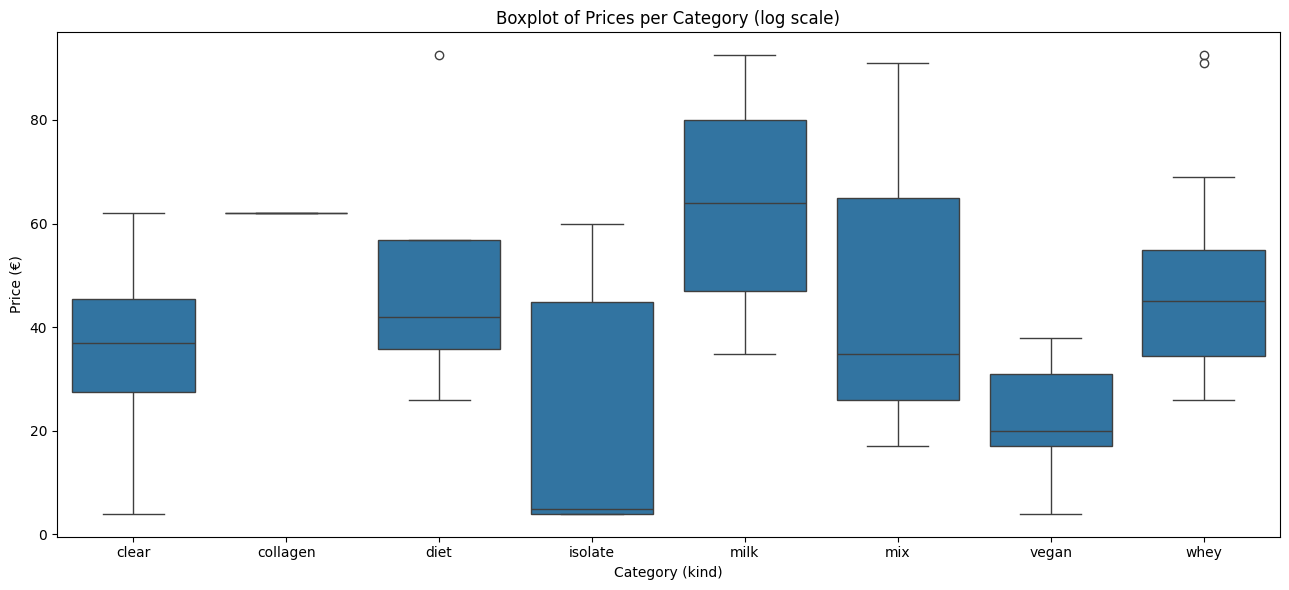

outliers:
 Diet:
 Product: Grass-Fed Impact Whey Isolate Price: 92.49 Rating: 4.33 
Whey:
 Product: Grass-Fed Impact Whey Isolate Price:92.49 Rating: 4.00
 Product: Φόρμουλα Απόδοσης όλα σε ένα Price:90.99 Rating: 5.00


In [387]:
# price distributin per kind
df_plot = df_hier.reset_index().copy()

plt.figure(figsize=(13,6),dpi = 100)
sns.boxplot(data=df_plot, x="kind", y="price")
plt.xlabel("Category (kind)")
plt.ylabel("Price (€)")
plt.title("Boxplot of Prices per Category (log scale)")
plt.tight_layout()
plt.show()

print("outliers:\n Diet:\n Product: Grass-Fed Impact Whey Isolate Price: 92.49 Rating: 4.33 \nWhey:\n Product: Grass-Fed Impact Whey Isolate Price:92.49 Rating: 4.00\n Product: Φόρμουλα Απόδοσης όλα σε ένα Price:90.99 Rating: 5.00")

In [425]:
# value for money


dfv = df_hier.reset_index().copy()   


medians = (dfv.groupby("kind")[["price","rating"]]
              .median()
              .rename(columns={"price":"med_price", "rating":"med_rating"}))

dfv = dfv.merge(medians, on="kind", how="left")

mask = (dfv["rating"] > dfv["med_rating"]) & (dfv["price"] < dfv["med_price"])
vfm = dfv.loc[mask].copy()

vfm["value_score"] = (vfm["rating"] / vfm["price"]).round(4)

vfm = (vfm.sort_values(["kind","value_score"], ascending=[True, False])
          .set_index(["kind","product"])
          [["price","value_score"]])

pd.DataFrame(vfm)


vfm


price  value_score
kind    product                                                              
clear   Myprotein Clear Whey Isolate (Sample)               4.99       0.9359
        Clear Vegan Protein                                28.99       0.1725
        Clear Protein Variety Box                          27.99       0.1654
        Clear Vegan Protein Starter Pack                   31.99       0.1563
diet    Impact Diet Whey                                   25.99       0.1781
        Clear Whey Diet                                    38.99       0.1282
isolate Clear Vegan Protein (Δείγμα)                        3.99       1.2531
mix     Μείγμα Πρωτεϊνών για Αυστηρά Χορτοφάγους (Vegan)   16.99       0.2796
        Μείγμα για Pancake Πρωτεΐνης                       17.99       0.2529
        Πρωτεϊνούχο ατομικό κέικ                           24.99       0.1881
        Breakfast Smoothie                                 31.99       0.1563
        Φόρμουλα Αύξησης Βάρους                            33.99       0.1374
vegan   Clear Vegan Protein (Δείγμα)                        3.99       1.1779
        Μείγμα Πρωτεϊνών για Αυστηρά Χορτοφάγους (Vegan)   16.99       0.2796
whey    Clear Protein Water - RTD (Συσκευασία των 6)       26.99       0.1760
        Essential Whey Protein                             43.99       0.1053

In [ ]:
vfm_tbl = vfm.reset_index().copy()
vfm_tbl.loc[vfm_tbl["kind"].duplicated(), "kind"] = ""

header_color = "#A7C7FF"  


top3_idx = vfm_tbl["value_score"].nlargest(3).index

def highlight_top3_value(col: pd.Series):
    return [f"color: {header_color}; font-weight: 700;" if i in top3_idx else "" for i in col.index]

def color_kind(col: pd.Series):
   
    return [f"color: {header_color}; font-weight: 600;" if isinstance(x, str) and x != "" else "" for x in col]


sty = (
    vfm_tbl.style
      .format({"price": lambda x: f"€{x:,.2f}", "value_score": lambda x: f"{x*100:.2f}%"})
      .background_gradient(subset=["value_score"], cmap="cividis", vmin=0, vmax=1)
      .bar(subset=["value_score"], color="#3B82F6", vmin=0, vmax=1, align="left")
      .set_table_styles([
          {"selector":"table","props":[("border-collapse","separate"),("border-spacing","0"),("width","100%"),
            ("font-family","Inter, system-ui, Segoe UI, Roboto, sans-serif"),("background","#1E1E24"),
            ("color","#E0E0E0"),("border","1px solid #2A2A32"),("border-radius","12px"),
            ("box-shadow","0 4px 18px rgba(0,0,0,0.4)"),("overflow","hidden")]},
          {"selector":"thead th","props":[("background","#2B2B33"),("color",header_color),
            ("text-transform","uppercase"),("letter-spacing",".03em"),("font-weight","600"),
            ("padding","12px 14px"),("border-bottom","1px solid #2A2A32")]},
          {"selector":"tbody td","props":[("padding","10px 14px"),("border-bottom","1px solid #2C2C34"),
            ("vertical-align","middle"),("background","#24242A")]},
          {"selector":"tbody tr:nth-child(even) td","props":[("background","#2A2A30")]},
          {"selector":"tbody tr:hover td","props":[("background","#33333D")]},
          {"selector":"caption","props":[("caption-side","top"),("text-align","left"),("padding","14px"),
            ("font-weight","700"),("font-size","1.05rem"),("color",header_color)]}
      ])
      .set_properties(subset=["kind","product"], **{"text-align":"left","white-space":"nowrap"})
      .set_properties(subset=["price","value_score"], **{"text-align":"right"})
      .apply(highlight_top3_value, subset=["value_score"])  
      .apply(color_kind, subset=["kind"])                   
      .hide(axis="index")
      .set_caption("Value-for-Money Products Per Category")
)

sty


kind,product,price,value_score
clear,Myprotein Clear Whey Isolate (Sample),€4.99,93.59%
,Clear Vegan Protein,€28.99,17.25%
,Clear Protein Variety Box,€27.99,16.54%
,Clear Vegan Protein Starter Pack,€31.99,15.63%
diet,Impact Diet Whey,€25.99,17.81%
,Clear Whey Diet,€38.99,12.82%
isolate,Clear Vegan Protein (Δείγμα),€3.99,125.31%
mix,Μείγμα Πρωτεϊνών για Αυστηρά Χορτοφάγους (Vegan),€16.99,27.96%
,Μείγμα για Pancake Πρωτεΐνης,€17.99,25.29%
,Πρωτεϊνούχο ατομικό κέικ,€24.99,18.81%
